# 2D Case

In [1]:
from core.runner import Runner
import tensorflow as tf

grid_dim = 2
grid_length = 8

runner = Runner(
    grid_dimension=grid_dim, grid_length=grid_length,
    main_layer_hidden_nodes=[30, 20],
    branch1_hidden_nodes=[10],
    branch2_hidden_nodes=[10],
    exploration_rate=0.5,
    learning_rate=0.0005
)

2022-12-07 11:49:03.712098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import time

batch_size = tf.constant(500)
n_iterations = tf.constant(int(1e4))
check_loss_every_n_iterations = tf.constant(int(1e3))

start = time.time()
ave_losses = runner.train_agent(batch_size, n_iterations, check_loss_every_n_iterations)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")

Iteration: 0 Average Loss: 11.0757008
Iteration: 1000 Average Loss: 2.35838366
Iteration: 2000 Average Loss: 1.60693336
Iteration: 3000 Average Loss: 1.02539337
Iteration: 4000 Average Loss: 0.559286475
Iteration: 5000 Average Loss: 0.237496018
Iteration: 6000 Average Loss: 0.107736617
Iteration: 7000 Average Loss: 0.0252121016
Iteration: 8000 Average Loss: 0.00304357824
Iteration: 9000 Average Loss: 0.000116867421
Time Elapsed: 396.2505569458008 s


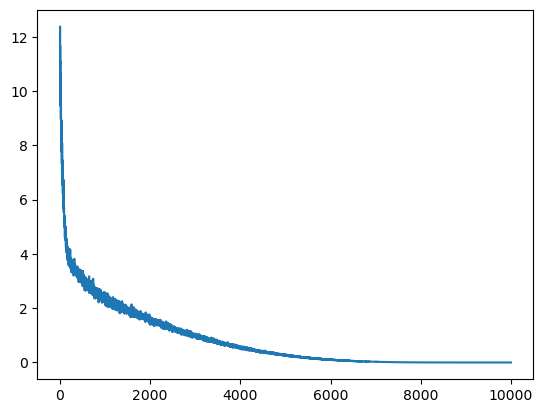

In [3]:
import matplotlib.pyplot as plt

plt.plot(ave_losses.numpy())

# Continue Training

Iteration: 0 Average Loss: 3.33287517e-06
Iteration: 1000 Average Loss: 1.96880208e-07
Iteration: 2000 Average Loss: 5.0726095e-07
Iteration: 3000 Average Loss: 8.80434618e-06
Iteration: 4000 Average Loss: 5.14805905e-08
Iteration: 5000 Average Loss: 2.16652224e-05
Iteration: 6000 Average Loss: 3.81775908e-06
Iteration: 7000 Average Loss: 3.82091275e-06
Iteration: 8000 Average Loss: 0.000111521185
Iteration: 9000 Average Loss: 1.00430475e-09
Iteration: 10000 Average Loss: 4.05746641e-06
Iteration: 11000 Average Loss: 2.12892246e-06
Iteration: 12000 Average Loss: 4.76991263e-05
Iteration: 13000 Average Loss: 6.84952706e-10
Iteration: 14000 Average Loss: 5.54138033e-08
Time Elapsed: 528.7723278999329 s


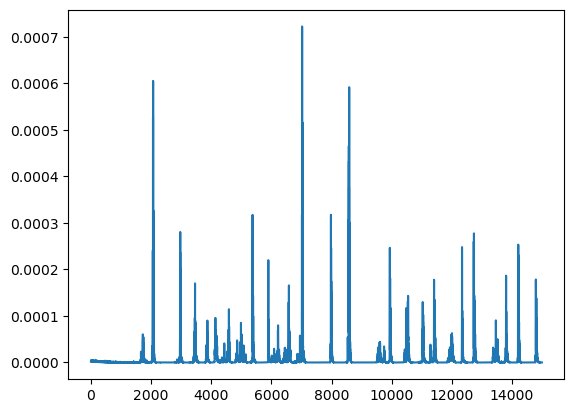

In [4]:
batch_size = tf.constant(500)
n_iterations = tf.constant(int(1.5e4))
check_loss_every_n_iterations = tf.constant(int(1e3))

start = time.time()
ave_losses = runner.train_agent(batch_size, n_iterations, check_loss_every_n_iterations)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")

plt.plot(ave_losses.numpy())

In [5]:
batch_size = tf.constant(5000)

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

agent_distr

Percentage of coordinates sampled uniquely: 39.06%


<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[0.0528, 0.0516, 0.    , 0.    , 0.    , 0.0002, 0.047 , 0.0536],
       [0.053 , 0.1064, 0.0002, 0.    , 0.    , 0.    , 0.0922, 0.0486],
       [0.    , 0.0002, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.0002, 0.    , 0.    , 0.0002, 0.    , 0.    , 0.0002, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.0002, 0.    , 0.    , 0.    , 0.    , 0.0004],
       [0.0458, 0.1   , 0.    , 0.    , 0.0002, 0.    , 0.0962, 0.0526],
       [0.0506, 0.048 , 0.    , 0.    , 0.    , 0.    , 0.0542, 0.0454]],
      dtype=float32)>

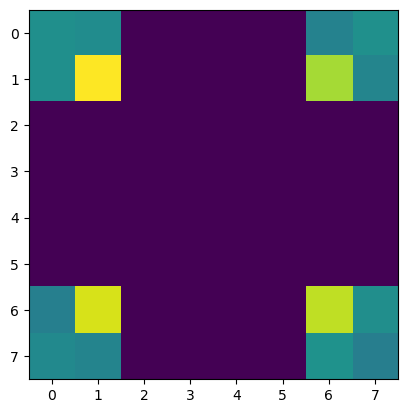

In [6]:
plt.imshow(agent_distr.numpy())

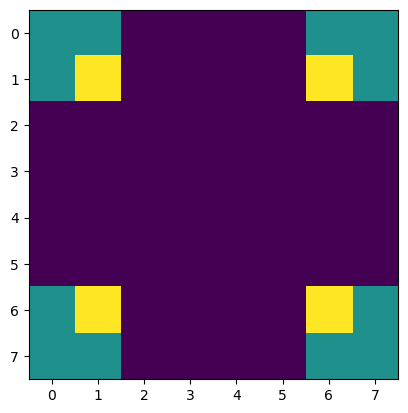

In [7]:
env_distr = runner.env.rewards / tf.math.reduce_sum(runner.env.rewards)

plt.imshow(env_distr.numpy())

In [1]:
from core.runner import Runner
import tensorflow as tf
import time
import matplotlib.pyplot as plt

import numpy as np

def _plot_l1_errors_per_probability_interval(agent_prob, env_prob, 
#                                              filename, 
                                             n_intervals
                                            ):
    result = agent_prob.ravel()
    expected = env_prob.ravel()
    max_expected = expected.max()
    expected_pcts = expected * 100 / max_expected

    interval_edges = np.linspace(0, 100, n_intervals + 1)
    starts = interval_edges[:-1]
    ends = interval_edges[1:]

    frac_l1_errors = np.abs(result - expected) / max_expected
    errors = []
    labels = []
    for s, e in zip(starts, ends):
        inds = np.where((s < expected_pcts) & (expected_pcts <= e))
        errors_per_interval = frac_l1_errors[inds]
        if len(errors_per_interval):
            interval_label = f"{s:.2f}% < pct <= {e:.2f}%"
            errors.append(errors_per_interval)
            labels.append(interval_label)

#     print(errors)
    fig, ax = plt.subplots()
    ax.violinplot(errors)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels, rotation=15)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Fractional L1 Errors")
    ax.set_xlabel("Percentage of max theoretical probability")
    plt.tight_layout()
#     fig.savefig(f"./plot_results/{filename}")
    return errors

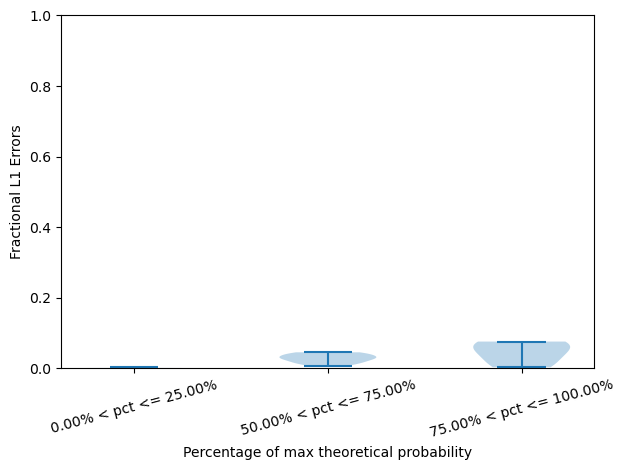

In [8]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

# 5D Case

In [2]:
grid_dim = 5
grid_length = 8

runner = Runner(
    grid_dimension=grid_dim, grid_length=grid_length,
    main_layer_hidden_nodes=[80, 40, 20],
    branch1_hidden_nodes=[10],
    branch2_hidden_nodes=[10],
    exploration_rate=0.5,
    learning_rate=0.005
)

2022-12-09 18:05:26.997005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
batch_size = tf.constant(500)
n_iterations = tf.constant(int(5e4))
check_loss_every_n_iterations = tf.constant(int(1e3))

start = time.time()
ave_losses = runner.train_agent(batch_size, n_iterations, check_loss_every_n_iterations)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")

Iteration: 0 Average Loss: 61.6634216
Iteration: 1000 Average Loss: 1.53919756
Iteration: 2000 Average Loss: 0.331700951
Iteration: 3000 Average Loss: 0.101429261
Iteration: 4000 Average Loss: 0.0259949416
Iteration: 5000 Average Loss: 0.0102489032
Iteration: 6000 Average Loss: 0.00640020706
Iteration: 7000 Average Loss: 0.00489899237
Iteration: 8000 Average Loss: 0.0047130431
Iteration: 9000 Average Loss: 0.00524962693
Iteration: 10000 Average Loss: 0.00311531313
Iteration: 11000 Average Loss: 0.00262189633
Iteration: 12000 Average Loss: 0.0022066324
Iteration: 13000 Average Loss: 0.00216165744
Iteration: 14000 Average Loss: 0.00533708185
Iteration: 15000 Average Loss: 0.00176363788
Iteration: 16000 Average Loss: 0.00102926802
Iteration: 17000 Average Loss: 0.0170390327
Iteration: 18000 Average Loss: 0.00065464183
Iteration: 19000 Average Loss: 0.00206190581
Iteration: 20000 Average Loss: 0.00348064117
Iteration: 21000 Average Loss: 0.00075089297
Iteration: 22000 Average Loss: 0.00141

In [8]:
ave_losses[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.00027887025>

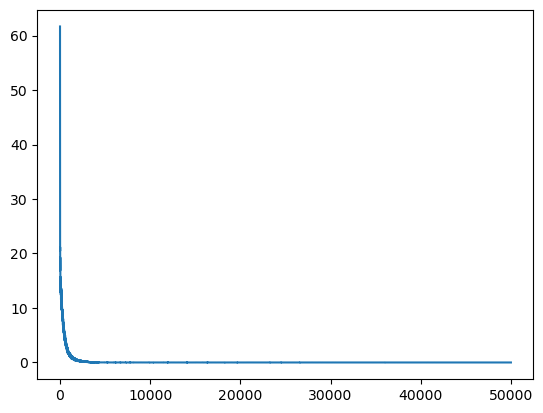

In [4]:
plt.plot(ave_losses.numpy())

In [5]:
# batch_size = tf.constant(int((grid_length ** grid_dim) * 100))
batch_size = tf.constant(int(5e4))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 7.43%


In [6]:
env_distr = runner.env.rewards / tf.math.reduce_sum(runner.env.rewards)

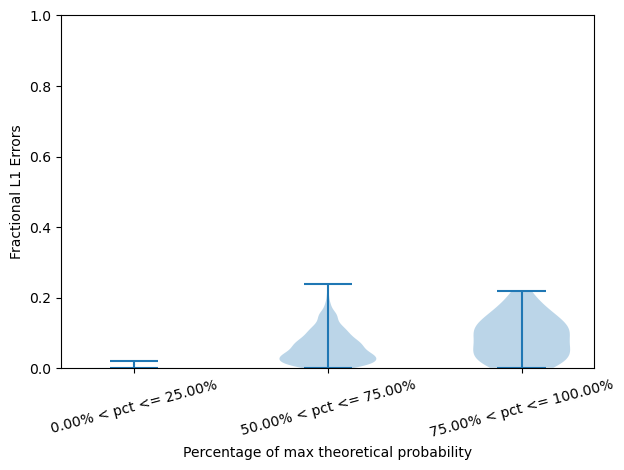

In [7]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

In [9]:
batch_size = tf.constant(int(1e5))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 11.56%


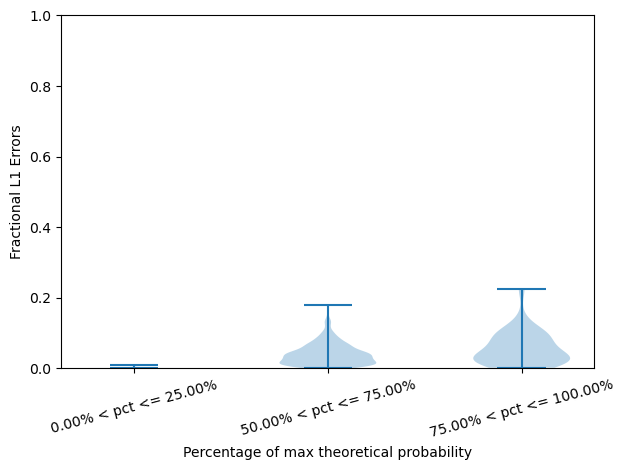

In [10]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

In [11]:
batch_size = tf.constant(int(5e5))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 38.75%


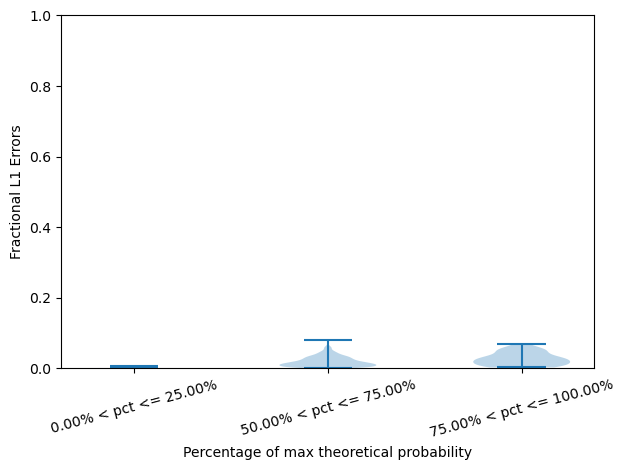

In [12]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)